In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, mean_squared_error
import pickle
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from itertools import combinations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_rating = pd.read_csv('/content/drive/MyDrive/Books/Ratings.csv')
df_books = pd.read_csv('/content/drive/MyDrive/Books/Books.csv')
df_users = pd.read_csv('/content/drive/MyDrive/Books/Users.csv')
df_images = df_books.iloc[:, -2:]
df_books = df_books.iloc[:, :-2]
userCounts = df_rating['User-ID'].value_counts()
isbnCounts = df_rating['ISBN'].value_counts()
dfr = df_rating
dfr = dfr[~dfr['ISBN'].isin(isbnCounts[isbnCounts < 100].index)]

dfr = pd.merge(right=dfr, left = df_books, on="ISBN")
dfr.head()
dfr = dfr[~dfr['User-ID'].isin(userCounts[userCounts < 200].index)]
dfr = dfr.drop_duplicates(["Book-Title", "User-ID"])
combine_book_rating = dfr
columns = ['Year-Of-Publication', 'Book-Author', 'Image-URL-S', 'Publisher']
combine_book_rating =  combine_book_rating.drop(columns, axis=1)
df_for_nn = combine_book_rating
combine_book_rating.shape[0]
unique_books = df_for_nn['Book-Title'].unique()
book_id_mapping = {book_title: book_id for book_id, book_title in enumerate(unique_books, start=1)}

df_for_nn['Book-ID'] = df_for_nn['Book-Title'].map(book_id_mapping)
train, test = train_test_split(df_for_nn, test_size=0.2, random_state=42)

# For neural network
with open('/content/drive/MyDrive/Neural Network/model(Final)', 'rb') as file:
    model_for_nn = pickle.load(file)
predicted_ratings = model_for_nn.predict([test['User-ID'], test['Book-ID']])

predicted_ratings_discrete = np.round(predicted_ratings).astype(int)

actual_ratings_discrete = test['Book-Rating'].values.astype(int)
precision = precision_score(actual_ratings_discrete, predicted_ratings_discrete, average='weighted')

<ipython-input-79-71a0de048ec0>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv('/content/drive/MyDrive/Books/Books.csv')


308/308 [==============================] - 0s 1ms/step


In [ ]:
print(train.shape)
print(test.shape)

(39308, 5)
(9828, 5)


Confusion Matrix:
[[4233 3135]
 [ 688 1772]]


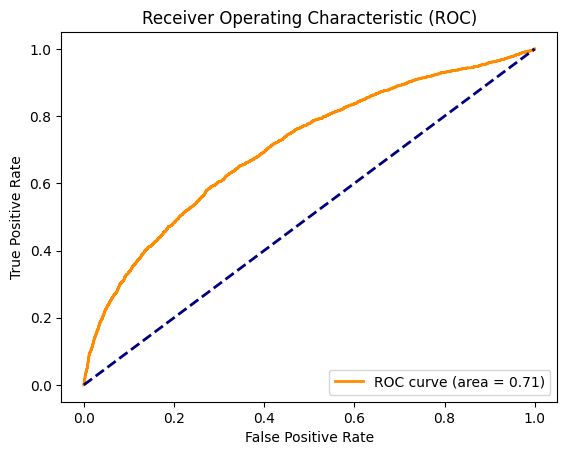

Precision: 0.5745114006514658
Recall: 0.8601910180857549
F1-score: 0.6889087802099438


In [ ]:
# Convert predicted ratings to binary classes based on a threshold
threshold = 1.5 # balanced performance at a threshold of 0.2
predicted_classes = (predicted_ratings > threshold).astype(int)
actual_classes = (test['Book-Rating'] > threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(actual_classes, predicted_ratings)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Find the index of the threshold closest to the chosen threshold
idx = np.argmin(np.abs(thresholds - threshold))

tp, fp = cm[0]  # True Positives, False Positives
fn, tn = cm[1]  # False Negatives, True Negatives

# Precision
precision = tp / (tp + fp) if (tp + fp) != 0 else 0

# Recall
recall = tp / (tp + fn) if (tp + fn) != 0 else 0

# F1-score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

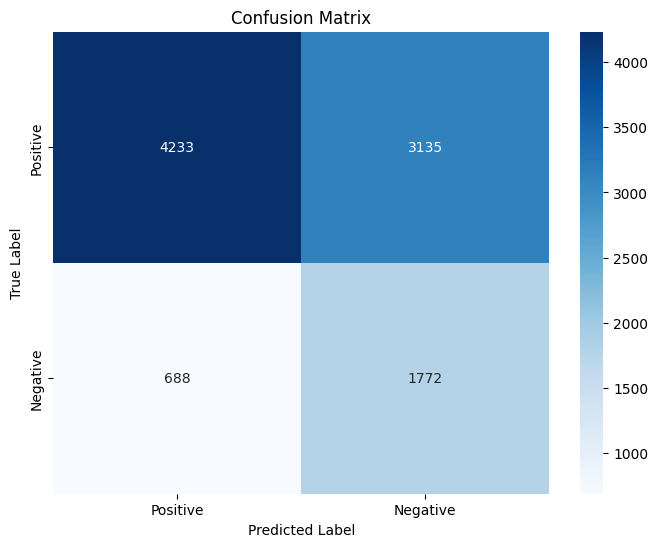

In [ ]:
# Visualizing confusion matrix
confusion_matrix = np.array([[4233, 3135], [688, 1772]])
class_labels = ["Positive", "Negative"]
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(test.shape)

(9828, 5)


In [ ]:
# KNN
book_pivot_test = test.pivot_table(columns='User-ID', index='Book-Title', values='Book-Rating')
book_pivot_test.fillna(0,inplace=True)
book_sparse_test = csr_matrix(book_pivot_test)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(book_sparse_test)
random_index = np.random.choice(book_sparse_test.shape[0])
distance, suggestion = model_knn.kneighbors(book_pivot_test.iloc[random_index,:].values.reshape(1,-1), n_neighbors=7)
book_name = book_pivot_test.index

def get_recommend_knn_test(book_name):
    try:
        book_id = np.where(book_pivot_test.index == book_name)[0][0]
    except IndexError:
        print("Book not found in the database.")
        return

    distance, suggestion = model_knn.kneighbors(book_pivot_test.iloc[book_id, :].values.reshape(1, -1), n_neighbors=7)

    recommended_books = []
    for i in range(len(suggestion)):
        books = book_pivot_test.index[suggestion[i]]
        for j in books:
          recommended_books.append(j)
    return recommended_books

In [ ]:
# Matrix Factorization
Trans = book_pivot_test
SVD = TruncatedSVD(n_components=20, random_state=10)
matrix = SVD.fit_transform(Trans)
corr = np.corrcoef(matrix)

def get_recommend_MF_test(name):
    """The function to get recommendations"""
    book_title = book_pivot_test.T.columns
    book_list = list(book_title)
    book_index = book_list.index(name)
    corr_book = corr[book_index]

    correlated_books = list(book_title[corr_book > 0.8])[:7]
    if name in correlated_books:
     correlated_books.remove(name)
    correlated_books.insert(0, name)

    if len(correlated_books) > 7:
        correlated_books.pop()

    return correlated_books

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
get_recommend_knn_test("The Bonfire of the Vanities")

['The Bonfire of the Vanities',
 'The Reptile Room (A Series of Unfortunate Events, Book 2)',
 'Forever... : A Novel of Good and Evil, Love and Hope',
 'Possession : A Romance',
 'Secret History',
 'Like Water for Chocolate : A Novel in Monthly Installments with Recipes, Romances, and Home Remedies',
 'The Remains of the Day (Vintage International)']

In [ ]:
get_recommend_MF_test("The Bonfire of the Vanities")

['The Bonfire of the Vanities',
 "CAT'S EYE",
 'FORREST GUMP (Movie Tie in)',
 'Girl, Interrupted',
 'Shopgirl',
 'The Hot Zone',
 'The Remains of the Day (Vintage International)']

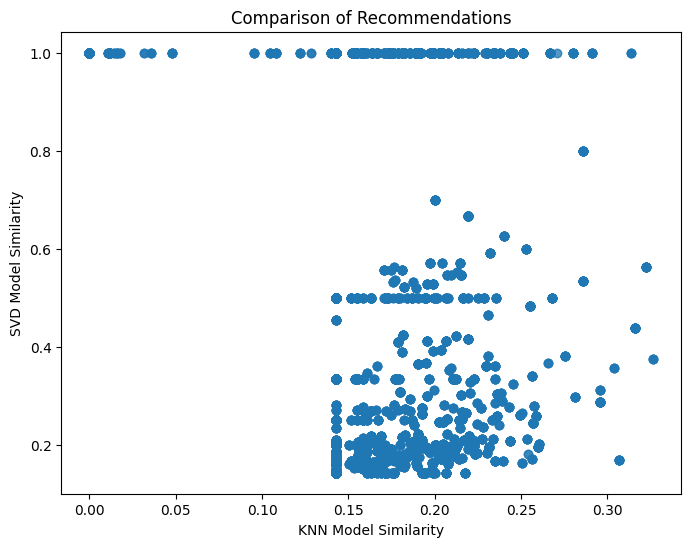

In [ ]:
knn_sim = []
svd_sim = []
def calculate_string_similarity(title1, title2):
    title1_set = set(title1.lower().split())
    title2_set = set(title2.lower().split())

    intersection = len(title1_set.intersection(title2_set))
    union = len(title1_set.union(title2_set))

    similarity = intersection / union if union != 0 else 0

    return similarity

def calculate_similarity(original_book, recommended_books):

    similarities = []
    for recommended_book in recommended_books:
        # Calculate similarity using a simple string similarity metric (e.g., Jaccard similarity)
        similarity = calculate_string_similarity(original_book, recommended_book)
        similarities.append(similarity)

    # Average similarity across all recommended books
    avg_similarity = sum(similarities) / len(similarities)

    return avg_similarity
    pass

def compare_recommendations(test_data):
    knn_similarities = []
    svd_similarities = []

    for book in test_data:
        knn_recommendations = get_recommend_knn_test(book)
        svd_recommendations = get_recommend_MF_test(book)

        # Calculate similarity/difference metric
        knn_similarity = calculate_similarity(book, knn_recommendations)
        svd_similarity = calculate_similarity(book, svd_recommendations)

        knn_similarities.append(knn_similarity)
        knn_sim.append(knn_similarity)
        svd_similarities.append(svd_similarity)
        svd_sim.append(svd_similarity)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(knn_similarities, svd_similarities, alpha=0.5)
    plt.xlabel('KNN Model Similarity')
    plt.ylabel('SVD Model Similarity')
    plt.title('Comparison of Recommendations')
    plt.show()


compare_recommendations(test['Book-Title'])

In the plot above, the points very close to or at 1 mean that the recommendations provided by the kNN model and the SVD model are pretty similar while the points very close to 0 mean that the recommendations provided by the models are very different.

In [ ]:
def get_confusion_matrix(knn_similarities, svd_similarities, threshold):
    knn_predictions = np.array([1 if similarity >= threshold else 0 for similarity in knn_similarities])
    svd_predictions = np.array([1 if similarity >= threshold else 0 for similarity in svd_similarities])

    # Calculate confusion matrix
    tp = np.sum(np.logical_and(knn_predictions == 1, svd_predictions == 1))
    fp = np.sum(np.logical_and(knn_predictions == 0, svd_predictions == 1))
    fn = np.sum(np.logical_and(knn_predictions == 1, svd_predictions == 0))
    tn = np.sum(np.logical_and(knn_predictions == 0, svd_predictions == 0))

    confusion_matrix = np.array([[tp, fp], [fn, tn]])

    return confusion_matrix

confusion_matrix = get_confusion_matrix(knn_sim, svd_sim, threshold=0.15)
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[5629 2613]
 [ 252 1334]]


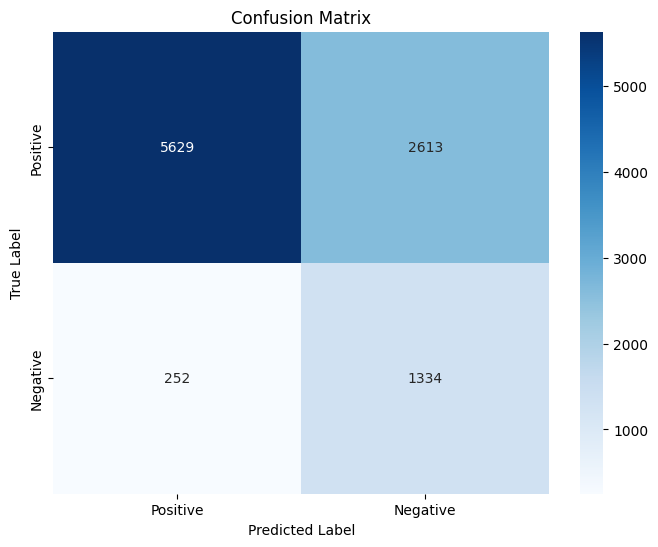

In [ ]:
# Visualizing confusion matrix
confusion_matrix = np.array([[5629, 2613], [252, 1334]])
class_labels = ["Positive", "Negative"]
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
tp, fp = confusion_matrix[0]  # True Positives, False Positives
fn, tn = confusion_matrix[1]  # False Negatives, True Negatives

# Precision
precision = tp / (tp + fp) if (tp + fp) != 0 else 0

# Recall
recall = tp / (tp + fn) if (tp + fn) != 0 else 0

# F1-score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Precision: 0.6829652996845426
Recall: 0.9571501445332427
F1-score: 0.7971394179706861


Above are the results when comparing the kNN model and the SVD model on the test dataset.

In [ ]:
# For Jaccard Similarity
pt = book_pivot_test
def jaccard_similarity(user1_interactions, user2_interactions):
    # Compute Jaccard similarity between two sets of interactions
    set1 = set(user1_interactions)
    set2 = set(user2_interactions)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0  # Handle division by zero
    return intersection / union

def compute_user_similarity_matrix(pt):
    users = pt.columns.tolist()
    user_similarity_matrix = pd.DataFrame(index=users, columns=users)
    for user1, user2 in combinations(users, 2):
      interac1 = pt[user1][pt[user1] > 0].index
      interac2 = pt[user2][pt[user2] > 0].index
      similarity = jaccard_similarity(interac1,interac2)
      user_similarity_matrix.loc[user1, user2] = similarity
      user_similarity_matrix.loc[user2, user1] = similarity
    return user_similarity_matrix

# Compute user-user similarity matrix using Jaccard similarity
user_similarity_matrix = compute_user_similarity_matrix(pt)
sorted_user_similarity_matrix = user_similarity_matrix.sort_values(by=user_similarity_matrix.columns.tolist(), ascending=False)

In [ ]:


def get_recommend_JS_test(book_name):

    # Check if the book name exists in the interaction matrix
    if book_name not in pt.index:
        print(f"Book '{book_name}' not found in the interaction matrix.")
        return []

    # Get interactions for the input book
    book_interactions = pt.loc[book_name]

    # Find users who have interacted with the input book
    interacting_users = book_interactions[book_interactions > 0].index.tolist()

    # Aggregate similarities for interacting users
    user_similarities = user_similarity_matrix.loc[interacting_users].sum()

    # Sort users by aggregated similarity
    most_similar_users = user_similarities.sort_values(ascending=False).index.tolist()

    # Get books interacted with by the most similar users
    recommended_books = []
    for user in most_similar_users:
        user_interactions = pt[user]
        user_books = user_interactions[user_interactions > 0].index.tolist()
        recommended_books.extend(user_books)

    # Remove books already interacted with by the target user
    recommended_books = [book for book in recommended_books if book not in pt.loc[book_name][pt.loc[book_name] > 0].index.tolist()]

    # Remove duplicates while preserving order
    recommended_books = list(dict.fromkeys(recommended_books))

    return recommended_books[:8]

In [ ]:
pt.index

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       'A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Confederacy of Dunces (Evergreen Book)',
       ...
       'Wicked: The Life and Times of the Wicked Witch of the West', 'Wifey',
       'Wild Animus', 'Winter Moon', 'Wish You Well', 'Without Remorse',
       'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       '\O\" Is for Outlaw"'],
      dtype='object', name='Book-Title', length=673)

In [ ]:
get_recommend_JS_test("Harry Potter and the Chamber of Secrets (Book 2)")

['Harry Potter and the Chamber of Secrets (Book 2)',
 "Harry Potter and the Sorcerer's Stone (Book 1)",
 "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
 'Red Dragon',
 'The Notebook',
 'C Is for Corpse (Kinsey Millhone Mysteries (Paperback))',
 'I Is for Innocent',
 'K Is for Killer (Kinsey Millhone Mysteries (Paperback))']

Comparing kNN and Jaccard Similarity

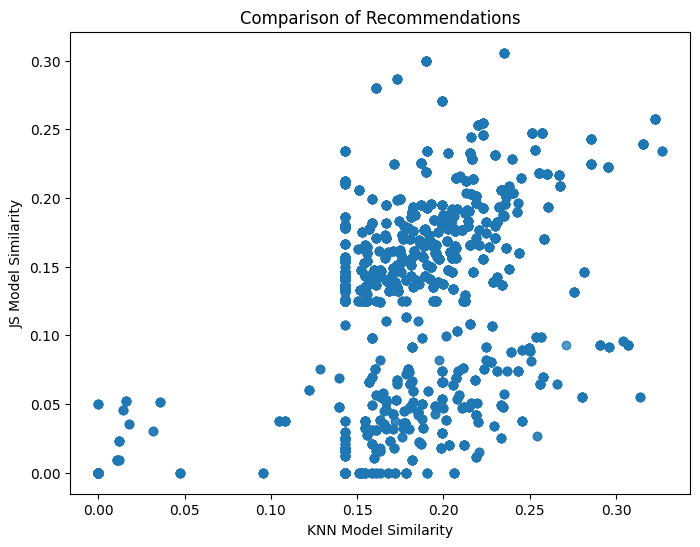

In [ ]:
knn_sim = []
js_sim = []

def compare_recommendations_2(test_data):
    knn_similarities = []
    js_similarities = []

    for book in test_data:
        knn_recommendations = get_recommend_knn_test(book)
        js_recommendations = get_recommend_JS_test(book)

        # Calculate similarity/difference metric
        knn_similarity = calculate_similarity(book, knn_recommendations)
        js_similarity = calculate_similarity(book, js_recommendations)

        knn_similarities.append(knn_similarity)
        knn_sim.append(knn_similarity)
        js_similarities.append(js_similarity)
        js_sim.append(js_similarity)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(knn_similarities, js_similarities, alpha=0.5)
    plt.xlabel('KNN Model Similarity')
    plt.ylabel('JS Model Similarity')
    plt.title('Comparison of Recommendations')
    plt.show()

compare_recommendations_2(test['Book-Title'])

In [ ]:
with open('/content/drive/MyDrive/Models Evaluation/knn_sim', 'wb') as file:
    pickle.dump(knn_sim, file)
with open('/content/drive/MyDrive/Models Evaluation/js_sim', 'wb') as file:
    pickle.dump(js_sim, file)

In [ ]:
with open('/content/drive/MyDrive/Models Evaluation/knn_sim', 'rb') as file:
    knn_sim = pickle.load(file)
    file.close()
with open('/content/drive/MyDrive/Models Evaluation/js_sim', 'rb') as file:
    js_sim = pickle.load(file)
    file.close()

In [ ]:
confusion_matrix_2 = get_confusion_matrix(knn_sim, js_sim, threshold=0.15) # best performing at a threshold of 0.1
print(confusion_matrix_2)

[[3197  255]
 [2684 3692]]


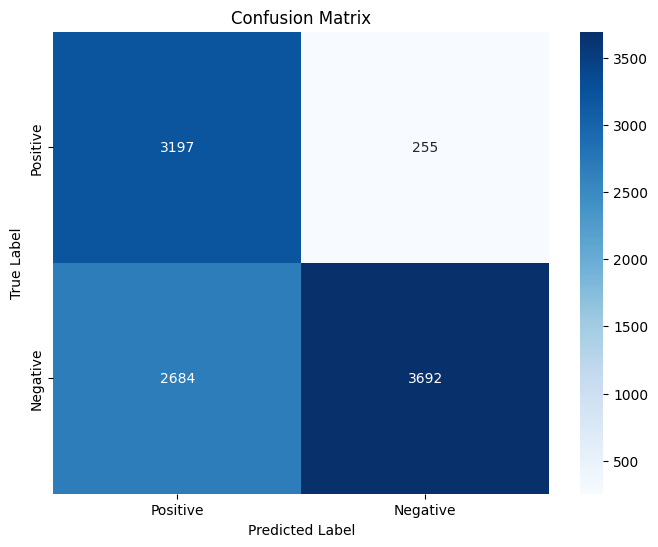

In [ ]:
# Visualizing confusion matrix
confusion_matrix = np.array([[3197, 255], [2684, 3692]])
class_labels = ["Positive", "Negative"]
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
tp, fp = confusion_matrix_2[0]  # True Positives, False Positives
fn, tn = confusion_matrix_2[1]  # False Negatives, True Negatives

# Precision
precision = tp / (tp + fp) if (tp + fp) != 0 else 0

# Recall
recall = tp / (tp + fn) if (tp + fn) != 0 else 0

# F1-score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Precision: 0.9261297798377752
Recall: 0.5436150314572351
F1-score: 0.6850958962820101


Above are the results comparing the kNN model and the Jaccard Similarity